In [2]:
#Importing and uploading data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

bids = pd.DataFrame.from_csv('C:/Users/Christopher Gardner/Documents/Python Scripts/bids.csv')
train = pd.DataFrame.from_csv('C:/Users/Christopher Gardner/Documents/Python Scripts/train.csv')

#adding final time features created by subtracting bid time from the last time in the auction. 
test_df = pd.DataFrame.from_csv('C:/Users/Christopher Gardner/Documents/Python Scripts/final_times.csv')
test_df.columns = ['f_time']
bids = bids.merge(test_df, left_on='auction', right_index=True)
test_df = pd.DataFrame.from_csv('C:/Users/Christopher Gardner/Documents/Python Scripts/short_times.csv')
test_df.columns = ['short_time']
bids = bids.merge(test_df, left_on='bidder_id', right_index=True)
bids['diff_time'] = bids.f_time - bids.time
#create proper merge
groupfirst = bids.groupby(bids.bidder_id).nunique().sort_index()
mergedsecond = groupfirst.merge(train.sort_index(), left_index=True, right_index=True)

#now sort by desired values, update ranking and then split into bots and humans for plotting
mergedsecond = mergedsecond.sort_values(by=['auction'])
mergedsecond['ranking'] = np.arange(len(mergedsecond))
mergedsecond['bids_per_auction'] = mergedsecond.time/mergedsecond.auction
bots = mergedsecond[mergedsecond.outcome==1]
humans = mergedsecond[mergedsecond.outcome==0]


#mergefirst
mergedfirst = bids.merge(train, left_on='bidder_id', right_index=True)
groupedsecond = mergedfirst.groupby('bidder_id').nunique()

In [16]:
#Creating Train Test splits and pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

#X and y 
X = mergedsecond.drop(['outcome', 'payment_account', 'address', 'diff_time'], axis=1)
y = mergedsecond.outcome

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#oversampled set
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_sample(X_train, y_train)
#undersampled set
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_sample(X_train, y_train)


smote = SMOTE(random_state = 42)
X_smote, y_smote = smote.fit_sample(X_train, y_train)

In [67]:
len(X_train), len(y_train[y_train==1])

(1388, 75)

In [71]:
def roc_report(model_title, model, x_test, x_train, y_test, y_train):
    print("Classification report and ROC curve for model type: " + model_title)
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)
    L = [x[1] for x in y_pred]
    report = classification_report(y_test, model.predict(X_test))
    print(report)
    auc  = roc_auc_score(y_test, L)
    print("AUC score: "+ str(auc))
    fpr, tpr, _ = roc_curve(y_test, L)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred[:, i])
    plt.title("ROC curve for " + model_title)
    plt.plot(fpr[1],tpr[1])
    plt.show()

Classification report and ROC curve for model type: Logistic Regression
             precision    recall  f1-score   support

        0.0       0.95      1.00      0.97       568
        1.0       0.00      0.00      0.00        28

avg / total       0.91      0.95      0.93       596

AUC score: 0.808790241449


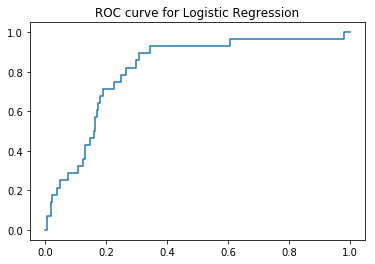

In [72]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
roc_report("Logistic Regression", logreg, X_test, X_train, y_test, y_train)


Classification report and ROC curve for model type: Logistic Regression post gridsearch
             precision    recall  f1-score   support

        0.0       0.95      1.00      0.97       568
        1.0       0.00      0.00      0.00        28

avg / total       0.91      0.95      0.93       596

AUC score: 0.41134305835


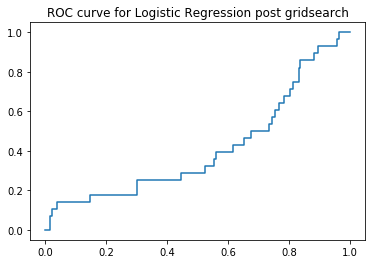

In [73]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'intercept_scaling': [0.001, 0.01, 0.1, 1 , 10] }
log_cv = GridSearchCV(logreg, param_grid)
roc_report("Logistic Regression post gridsearch", log_cv, X_test, X_train, y_test, y_train)

Classification report and ROC curve for model type: Logistic Regression w/ Oversampling
             precision    recall  f1-score   support

        0.0       0.99      0.77      0.87       568
        1.0       0.16      0.86      0.27        28

avg / total       0.95      0.78      0.84       596

AUC score: 0.848214285714


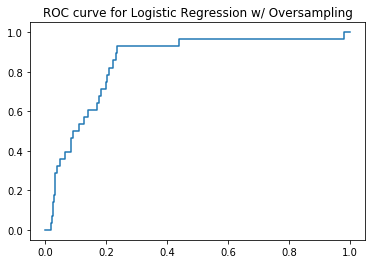

In [74]:
roc_report("Logistic Regression w/ Oversampling", log_cv, X_test, X_ros, y_test, y_ros)

Classification report and ROC curve for model type: Logistic Regression w/ Undersampling
             precision    recall  f1-score   support

        0.0       0.99      0.85      0.92       568
        1.0       0.22      0.86      0.35        28

avg / total       0.96      0.85      0.89       596

AUC score: 0.880030181087


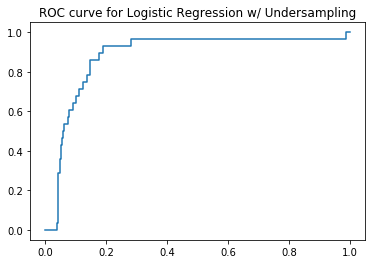

In [75]:
roc_report("Logistic Regression w/ Undersampling", log_cv, X_test, X_rus, y_test, y_rus)

Classification report and ROC curve for model type: Logistic Regression w/ SMOTE sampling
             precision    recall  f1-score   support

        0.0       0.99      0.78      0.87       568
        1.0       0.15      0.82      0.26        28

avg / total       0.95      0.78      0.84       596

AUC score: 0.835261569416


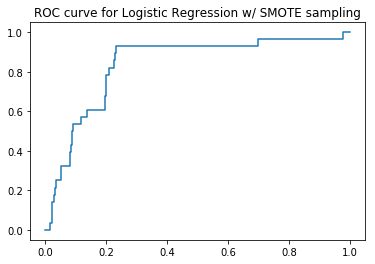

In [76]:
roc_report("Logistic Regression w/ SMOTE sampling", log_cv, X_test, X_smote, y_test, y_smote)

Classification report and ROC curve for model type: Random Forest w/ undersampling
             precision    recall  f1-score   support

        0.0       0.99      0.81      0.89       568
        1.0       0.19      0.89      0.31        28

avg / total       0.96      0.81      0.86       596

AUC score: 0.913135060362


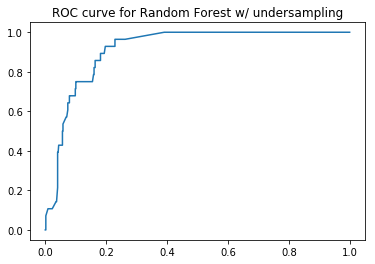

In [77]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=42)
roc_report("Random Forest w/ undersampling", forest, X_test, X_rus, y_test, y_rus)

Classification report and ROC curve for model type: Random Forest post gridsearch w/ Undersampling
             precision    recall  f1-score   support

        0.0       1.00      0.74      0.85       568
        1.0       0.16      0.96      0.27        28

avg / total       0.96      0.76      0.83       596

AUC score: 0.895089285714


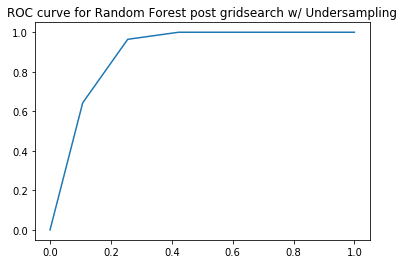

In [78]:
param_grid = {'n_estimators': [1,2,3,4,5,6,7,8,9,10]}#, 'max_depth': [1,2,3,4,5] }
cv_forest = GridSearchCV(forest, param_grid)
roc_report("Random Forest post gridsearch w/ Undersampling", cv_forest, X_test, X_rus, y_test, y_rus)

Classification report and ROC curve for model type: Support Vectors w/ Oversampling
             precision    recall  f1-score   support

        0.0       0.95      0.98      0.97       568
        1.0       0.00      0.00      0.00        28

avg / total       0.91      0.94      0.92       596

AUC score: 0.770089285714


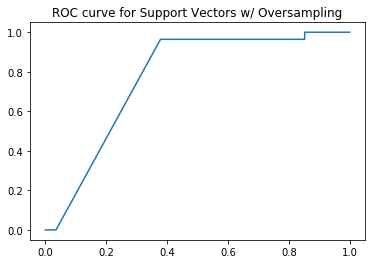

In [79]:
from sklearn.svm import SVC
svc = SVC(probability=True)
roc_report("Support Vectors w/ Oversampling", svc, X_test, X_ros, y_test, y_ros)

Classification report and ROC curve for model type: KNN w/ Undersampling
             precision    recall  f1-score   support

        0.0       0.95      0.98      0.97       568
        1.0       0.00      0.00      0.00        28

avg / total       0.91      0.93      0.92       596

AUC score: 0.773547535211


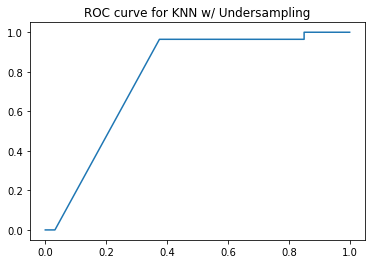

In [80]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'degree': [1,2,3,4,5] }
cv_svc= GridSearchCV(svc, param_grid)
roc_report("KNN w/ Undersampling", cv_svc, X_test, X_ros, y_test, y_ros)

Classification report and ROC curve for model type: KNN w/ Undersampling Post Gridsearch
             precision    recall  f1-score   support

        0.0       0.98      0.79      0.88       568
        1.0       0.15      0.75      0.25        28

avg / total       0.95      0.79      0.85       596

AUC score: 0.832180583501


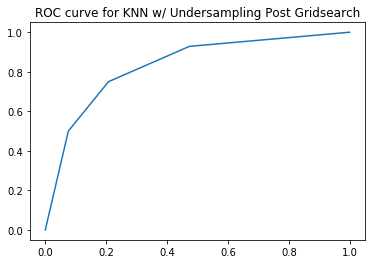

In [81]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10] }
cv_knn= GridSearchCV(knn, param_grid)
roc_report("KNN w/ Undersampling Post Gridsearch", cv_knn, X_test, X_rus, y_test, y_rus)